<a href="https://colab.research.google.com/github/pascalghanimi/Ski-Classification-AI/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import joblib
import numpy as np

pkl_name = "PHALP_AKatja_EKK"

# Lade die Daten
result = joblib.load(f"/content/{pkl_name}.pkl")

In [8]:
from typing_extensions import dataclass_transform
# Hier wird der COM berechnet

HAND_FOREARM_SCALE_FACTOR = 0.75

# Definiere die Segmente und relative Faktoren als Dictionary
segments = {
    "head_and_neck": {"points": (43, 40), "factor": 0.567}, # 43 ist Head, 40 ist Thorax
    "torso": {"points": (40, 8), "factor": 0.562}, # 40 ist Thorax, 8 ist Mid Hip
    "upper_arm_right": {"points": (2, 3), "factor": 0.564},  # 2 ist rechte Schulter, 3 ist rechter Ellbogen
    "upper_arm_left": {"points": (5, 6), "factor": 0.564},  # 5 ist linke Schulter, 6 ist linker Ellbogen
    "lower_arm_right": {"points": (3, 4), "factor": 0.57}, # 3 ist rechter Ellbogen, 4 ist rechtes Handgelenk
    "lower_arm_left": {"points": (6, 7), "factor": 0.57}, # 6 ist linker Ellbogen, 7 ist linkes Handgelenk
    "hand_right": {"factor": 0.468}, # Faktor ist hier 46.8, weil wir bei der Berechnung später bei der Wrist anfangen und die Länge des Ellbogens hinzuaddieren, hier also in die andere Richtung gehen als sonst
    "hand_left": {"factor": 0.468},
    "thigh_right": {"points": (9, 10), "factor": 0.567},  # 9 ist rechte Hüfte, 10 ist rechtes Knie
    "thigh_left": {"points": (12, 13), "factor": 0.567}, # 12 ist linke Hüfte, 13 ist linkes Knie
    "calf_right": {"points": (10, 11), "factor": 0.567}, # 10 ist rechtes Knie, 11 ist rechtes Ankle
    "calf_left": {"points": (13, 14), "factor": 0.567}, # 13 ist linkes Knie, 14 ist linkes Ankle
    "foot_right": {"points": (11, 22), "factor": 0.5}, # 11 ist rechtes Ankle, 22 ist großer Zeh rechts
    "foot_left": {"points": (14, 19), "factor": 0.5} # 14 ist linkes Ankle, 19 ist großer Zeh links
}


com_of_segments = {}

for i, frame in enumerate(list(result.keys())):
  com_of_segment = {}
  for segment, data in segments.items():
    if (segment == "hand_right"):
      com_position = np.array(result[frame]["3d_joints"][0][4]) + (
      (np.array(result[frame]["3d_joints"][0][4]) - np.array(result[frame]["3d_joints"][0][3]))
      * HAND_FOREARM_SCALE_FACTOR
      ) * data["factor"]
      com_of_segment[segment] = com_position
    elif segment == "hand_left":
      com_position = np.array(result[frame]["3d_joints"][0][7]) + (
      (np.array(result[frame]["3d_joints"][0][7]) - np.array(result[frame]["3d_joints"][0][6]))
      * HAND_FOREARM_SCALE_FACTOR
      ) * data["factor"]
      com_of_segment[segment] = com_position
    else:
      point_higher, point_lower = data["points"]
      com_position = np.array(result[frame]["3d_joints"][0][point_lower]) + ((np.array(result[frame]["3d_joints"][0][point_higher]) - np.array(result[frame]["3d_joints"][0][point_lower])) * data["factor"])
      com_of_segment[segment] = com_position


  com_of_segments[i] = com_of_segment


for i in range(3):
  print(com_of_segments[i]["head_and_neck"], "Head and Neck COM")

for i in range(3):
    print(com_of_segments[i]["lower_arm_right"], "Lower Arm Right COM")

for i in range(3):
  print(com_of_segments[i]["hand_right"], "Hand Right COM")



[ 0.3302517  -0.7274865   0.16042714] Head and Neck COM
[ 0.3122828  -0.71224964  0.1974359 ] Head and Neck COM
[ 0.29638097 -0.71066463  0.23467377] Head and Neck COM
[ 0.63668185 -0.24546269  0.05225378] Lower Arm Right COM
[ 0.6241803  -0.2346955   0.08284385] Lower Arm Right COM
[ 0.60786843 -0.23954184  0.10026369] Lower Arm Right COM
[ 0.81166816 -0.11841875  0.15246843] Hand Right COM
[ 0.8005574  -0.10744685  0.18526626] Hand Right COM
[ 0.7744216  -0.10635306  0.21582656] Hand Right COM


In [9]:
relative_masses = {
    "head_and_neck": 0.082,  # Beispiel aus Tabelle Hall
    "torso": 0.4684,
    "upper_arm_right": 0.0325,
    "upper_arm_left": 0.0325,
    "lower_arm_right": 0.0196,  # Unterarmgewicht, basierend auf Literaturwerten
    "lower_arm_left": 0.0196,
    "hand_right": 0.0061,  # Handgewicht, basierend auf Literaturwerten
    "hand_left": 0.0061,
    "thigh_right": 0.105,
    "thigh_left": 0.105,
    "calf_right": 0.0475,
    "calf_left": 0.0475,
    "foot_right": 0.0143,
    "foot_left": 0.0143
}


# Liste, die die COMs für alle Frames speichert
COM_xyz_values = {}

for frame in com_of_segments:
  COM_xyz = np.sum([
    np.array(com_of_segments[frame][segment]) * relative_masses[segment]
    for segment in relative_masses.keys()
  ], axis=0)
  COM_xyz_values[frame] = COM_xyz

print(COM_xyz_values)


{0: array([ 0.09464105, -0.2977307 ,  0.12338394], dtype=float32), 1: array([ 0.09527231, -0.28658515,  0.13970357], dtype=float32), 2: array([ 0.09430653, -0.28537452,  0.15167646], dtype=float32), 3: array([ 0.10010895, -0.28277355,  0.143333  ], dtype=float32), 4: array([ 0.09304628, -0.2760312 ,  0.13881236], dtype=float32), 5: array([ 0.08632486, -0.27806798,  0.14458488], dtype=float32), 6: array([ 0.08547436, -0.276366  ,  0.13737835], dtype=float32), 7: array([ 0.08966162, -0.27560812,  0.134148  ], dtype=float32), 8: array([ 0.09676463, -0.2822408 ,  0.12217329], dtype=float32), 9: array([ 0.09921426, -0.28755122,  0.12149733], dtype=float32), 10: array([ 0.09821127, -0.2935208 ,  0.10834575], dtype=float32), 11: array([ 0.10874131, -0.30161363,  0.11400574], dtype=float32), 12: array([ 0.1178755 , -0.31143415,  0.12810491], dtype=float32), 13: array([ 0.12324781, -0.31788835,  0.14418547], dtype=float32), 14: array([ 0.11894035, -0.3192284 ,  0.13305268], dtype=float32), 15: 

In [10]:
r_ankle = {}
l_ankle = {}
center_ankle = {}

for i, frame in enumerate(list(result.keys())):
  r_ankle[i] = result[frame]["3d_joints"][0][11]
  l_ankle[i] = result[frame]["3d_joints"][0][14]
  center_ankle[i] = (result[frame]["3d_joints"][0][11] + result[frame]["3d_joints"][0][14]) / 2

print(len(r_ankle))
print(len(COM_xyz_values))


186
186


In [11]:
COM_to_ground = {}

for i in COM_xyz_values:
  distance = np.linalg.norm(COM_xyz_values[i] - center_ankle[i])
  COM_to_ground[i] = distance

print(COM_to_ground)

{0: np.float32(0.7292355), 1: np.float32(0.73043066), 2: np.float32(0.74673116), 3: np.float32(0.7830828), 4: np.float32(0.8178987), 5: np.float32(0.8205116), 6: np.float32(0.8378239), 7: np.float32(0.8452063), 8: np.float32(0.8408417), 9: np.float32(0.82669276), 10: np.float32(0.82438695), 11: np.float32(0.78465956), 12: np.float32(0.7849536), 13: np.float32(0.7628496), 14: np.float32(0.7318114), 15: np.float32(0.70748025), 16: np.float32(0.6569973), 17: np.float32(0.6270044), 18: np.float32(0.6625599), 19: np.float32(0.71619207), 20: np.float32(0.7357655), 21: np.float32(0.76961696), 22: np.float32(0.8049782), 23: np.float32(0.8279485), 24: np.float32(0.85313123), 25: np.float32(0.8545417), 26: np.float32(0.8573738), 27: np.float32(0.8570687), 28: np.float32(0.84377265), 29: np.float32(0.833208), 30: np.float32(0.823153), 31: np.float32(0.7836964), 32: np.float32(0.74356693), 33: np.float32(0.72746825), 34: np.float32(0.71044046), 35: np.float32(0.7121442), 36: np.float32(0.73348856)

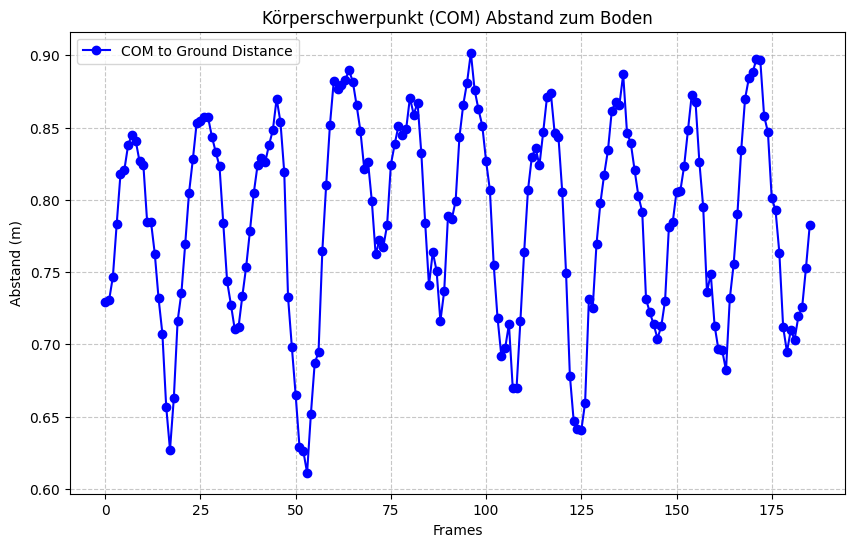

In [12]:
import matplotlib.pyplot as plt

# COM_to_ground-Daten, die bereits berechnet
frames = list(COM_to_ground.keys())
distances = list(COM_to_ground.values())

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(frames, distances, marker='o', linestyle='-', color='b', label="COM to Ground Distance")
plt.title("Körperschwerpunkt (COM) Abstand zum Boden")
plt.xlabel("Frames")
plt.ylabel("Abstand (m)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()


In [13]:
# Hier wird das Feature Kniewinkel für jeden Frame berechnet
r_hip_num = 9
r_knee_num = 10
r_ankle_num = 11
r_shoulder_num = 2
r_ellbow_num = 3
l_hip_num = 12
l_knee_num = 13
l_ankle_num = 14
l_shoulder_num = 5
l_ellbow_num = 6


knee_angles_right = {}
knee_angles_left = {}

for i, frame in enumerate(list(result.keys())):
  vector_right_hip_knee = result[frame]['3d_joints'][0][r_knee_num] - result[frame]['3d_joints'][0][r_hip_num]
  vector_left_hip_knee = result[frame]['3d_joints'][0][l_knee_num] - result[frame]['3d_joints'][0][l_hip_num]
  vector_right_knee_ankle =  result[frame]['3d_joints'][0][r_knee_num] - result[frame]['3d_joints'][0][r_ankle_num] # hier Änderung, nur wenn beide Winkel zum Knie zeigen, berechnet man wirklich den Innenwinkel, ansonsten den Außenwinkel
  vector_left_knee_ankle =  result[frame]['3d_joints'][0][l_knee_num] - result[frame]['3d_joints'][0][l_ankle_num]

  right_leg_dot_product = np.dot(vector_right_hip_knee, vector_right_knee_ankle)
  left_leg_dot_product = np.dot(vector_left_hip_knee, vector_left_knee_ankle)

  right_hip_knee_length = np.linalg.norm(vector_right_hip_knee)
  left_hip_knee_length = np.linalg.norm(vector_left_hip_knee)
  right_knee_ankle_length = np.linalg.norm(vector_right_knee_ankle)
  left_knee_ankle_length = np.linalg.norm(vector_left_knee_ankle)


  knee_angle_right = np.degrees(np.arccos(right_leg_dot_product / (right_hip_knee_length * right_knee_ankle_length)))
  knee_angle_left = np.degrees(np.arccos(left_leg_dot_product / (left_hip_knee_length * left_knee_ankle_length)))

  knee_angles_right[i] = knee_angle_right
  knee_angles_left[i] = knee_angle_left


for i in range(5):
  print(knee_angles_right)


{0: np.float32(84.25099), 1: np.float32(86.704155), 2: np.float32(93.30433), 3: np.float32(103.625656), 4: np.float32(114.15442), 5: np.float32(116.81889), 6: np.float32(123.75515), 7: np.float32(128.38025), 8: np.float32(129.82233), 9: np.float32(127.87918), 10: np.float32(125.73211), 11: np.float32(123.13787), 12: np.float32(126.49567), 13: np.float32(126.433655), 14: np.float32(119.58475), 15: np.float32(110.64663), 16: np.float32(102.266754), 17: np.float32(98.08812), 18: np.float32(108.20729), 19: np.float32(118.06529), 20: np.float32(121.70854), 21: np.float32(129.22307), 22: np.float32(134.51802), 23: np.float32(134.56067), 24: np.float32(136.58485), 25: np.float32(133.53874), 26: np.float32(128.94186), 27: np.float32(125.542984), 28: np.float32(119.04949), 29: np.float32(115.601875), 30: np.float32(111.44146), 31: np.float32(97.53166), 32: np.float32(84.698494), 33: np.float32(82.373535), 34: np.float32(80.52694), 35: np.float32(82.4313), 36: np.float32(89.95249), 37: np.float3

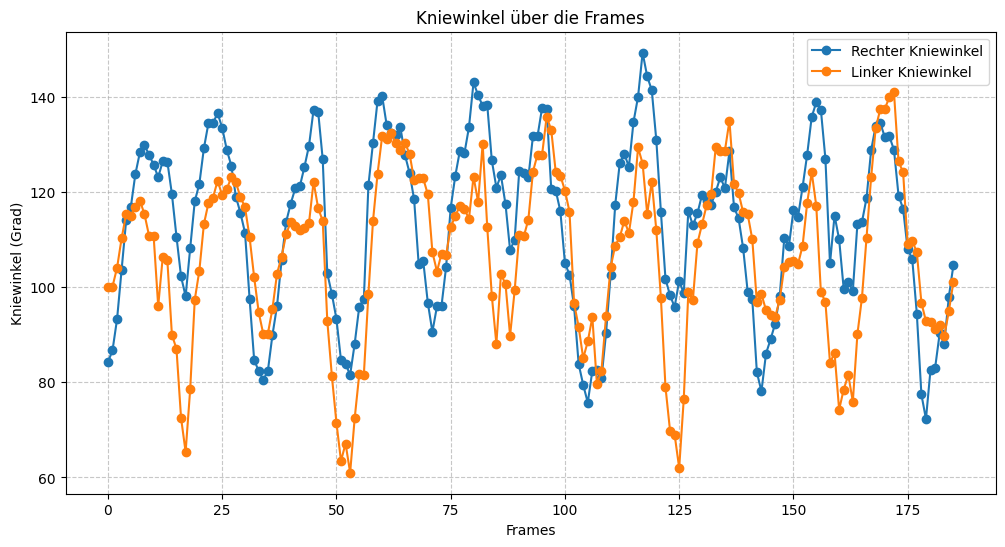

In [14]:
import matplotlib.pyplot as plt

# Frames extrahieren
frames = list(knee_angles_right.keys())

# Kniewinkel extrahieren
right_knee_angles = [knee_angles_right[frame] for frame in frames]
left_knee_angles = [knee_angles_left[frame] for frame in frames]


# Plot erstellen
plt.figure(figsize=(12, 6))

# Kniewinkel (rechts) plotten
plt.plot(frames, right_knee_angles, label="Rechter Kniewinkel", linestyle='-', marker='o')

# Kniewinkel (links) plotten
plt.plot(frames, left_knee_angles, label="Linker Kniewinkel", linestyle='-', marker='o')

# Plot-Details
plt.title("Kniewinkel über die Frames")
plt.xlabel("Frames")
plt.ylabel("Kniewinkel (Grad)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


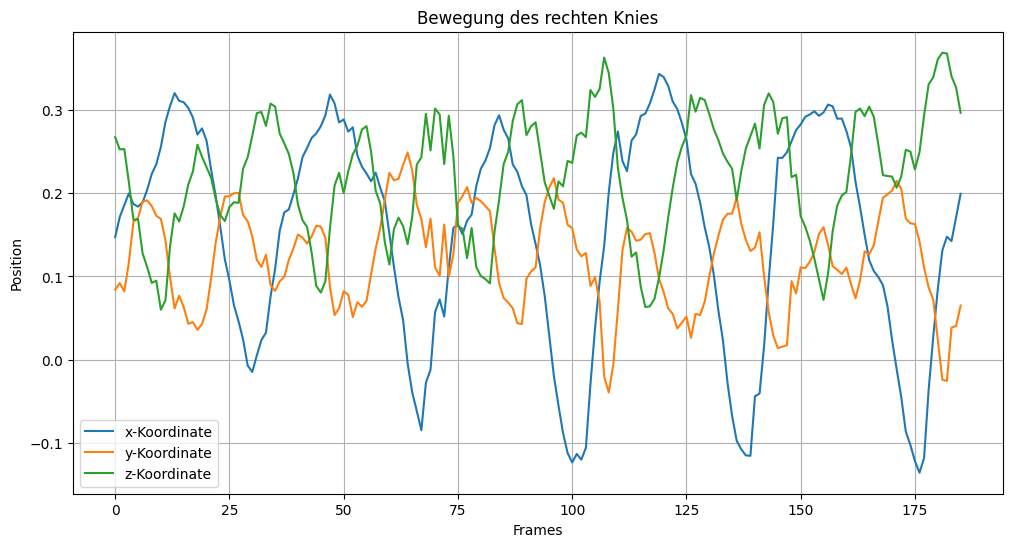

In [15]:
#exemplarische Darstellung des rechten Knies

import matplotlib.pyplot as plt

x_coords = [result[frame]['3d_joints'][0][r_knee_num][0] for frame in result.keys()]
y_coords = [result[frame]['3d_joints'][0][r_knee_num][1] for frame in result.keys()]
z_coords = [result[frame]['3d_joints'][0][r_knee_num][2] for frame in result.keys()]

plt.figure(figsize=(12, 6))
plt.plot(x_coords, label="x-Koordinate")
plt.plot(y_coords, label="y-Koordinate")
plt.plot(z_coords, label="z-Koordinate")
plt.title("Bewegung des rechten Knies")
plt.xlabel("Frames")
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.show()

# x-Achse: Die Bewegung des Knies entlang der x-Achse ist logisch, da der Fahrer nach rechts und links fährt. Die starke Veränderung in den Werten passt zu einer Schwungbewegung.
# y-Achse: Diese sollte stabil bleiben, da das Knie (wie du sagst) nicht groß um die y-Achse rotiert. Die minimalen Änderungen könnten durch Tracking-Rauschen entstehen.
# z-Achse: Leichte Schwankungen in z sind plausibel, da das Knie aufgrund von Hoch- und Tiefbewegungen während des Fahrens minimal variiert.

In [16]:
import numpy as np

def calculate_joint_angles(result):
    axis_vectors = {
        "x": np.array([1, 0, 0]),
        "y": np.array([0, 1, 0]),
        "z": np.array([0, 0, -1])
    }
    joint_angles = {}

    for i, frame in enumerate(result.keys()):
        joint_angles[i] = {}

        joints = result[frame]['3d_joints'][0]
        vectors = {
            "shoulder_to_ellbow_right": joints[r_ellbow_num] - joints[r_shoulder_num],
            "shoulder_to_ellbow_left": joints[l_ellbow_num] - joints[l_shoulder_num],
            "hip_to_knee_right": joints[r_knee_num] - joints[r_hip_num],
            "hip_to_knee_left": joints[l_knee_num] - joints[l_hip_num],
            "knee_to_ankle_right": joints[r_ankle_num] - joints[r_knee_num],
            "knee_to_ankle_left": joints[l_ankle_num] - joints[l_knee_num]
        }

        for axis_name, axis_vector in axis_vectors.items():
            joint_angles[i][axis_name] = {}

            for joint_name, joint_vector in vectors.items():
                angle = np.degrees(np.arccos(
                    np.dot(joint_vector, axis_vector) / (np.linalg.norm(joint_vector) * np.linalg.norm(axis_vector))
                ))
                joint_angles[i][axis_name][f"{axis_name}_{joint_name}_axis_angle"] = angle

    return joint_angles

# Berechnung der Winkel
joint_angles = calculate_joint_angles(result)

# Beispiel-Ausgabe für Frame 0
print(joint_angles[0])


{'x': {'x_shoulder_to_ellbow_right_axis_angle': np.float64(56.76475772297335), 'x_shoulder_to_ellbow_left_axis_angle': np.float64(145.9076995533732), 'x_hip_to_knee_right_axis_angle': np.float64(67.51487042275136), 'x_hip_to_knee_left_axis_angle': np.float64(102.59706867480952), 'x_knee_to_ankle_right_axis_angle': np.float64(137.6052646642894), 'x_knee_to_ankle_left_axis_angle': np.float64(136.77991507947834)}, 'y': {'y_shoulder_to_ellbow_right_axis_angle': np.float64(36.130925112270134), 'y_shoulder_to_ellbow_left_axis_angle': np.float64(57.434129426705475), 'y_hip_to_knee_right_axis_angle': np.float64(55.06876860089737), 'y_hip_to_knee_left_axis_angle': np.float64(38.57888065740033), 'y_knee_to_ankle_right_axis_angle': np.float64(51.07850075878151), 'y_knee_to_ankle_left_axis_angle': np.float64(65.05039926968239)}, 'z': {'z_shoulder_to_ellbow_right_axis_angle': np.float64(77.4417228898873), 'z_shoulder_to_ellbow_left_axis_angle': np.float64(98.99741812960191), 'z_hip_to_knee_right_ax

{'x': {'x_shoulder_to_ellbow_right_axis_angle': np.float64(56.76475772297335), 'x_shoulder_to_ellbow_left_axis_angle': np.float64(145.9076995533732), 'x_hip_to_knee_right_axis_angle': np.float64(67.51487042275136), 'x_hip_to_knee_left_axis_angle': np.float64(102.59706867480952), 'x_knee_to_ankle_right_axis_angle': np.float64(137.6052646642894), 'x_knee_to_ankle_left_axis_angle': np.float64(136.77991507947834)}, 'y': {'y_shoulder_to_ellbow_right_axis_angle': np.float64(36.130925112270134), 'y_shoulder_to_ellbow_left_axis_angle': np.float64(57.434129426705475), 'y_hip_to_knee_right_axis_angle': np.float64(55.06876860089737), 'y_hip_to_knee_left_axis_angle': np.float64(38.57888065740033), 'y_knee_to_ankle_right_axis_angle': np.float64(51.07850075878151), 'y_knee_to_ankle_left_axis_angle': np.float64(65.05039926968239)}, 'z': {'z_shoulder_to_ellbow_right_axis_angle': np.float64(77.4417228898873), 'z_shoulder_to_ellbow_left_axis_angle': np.float64(98.99741812960191), 'z_hip_to_knee_right_ax

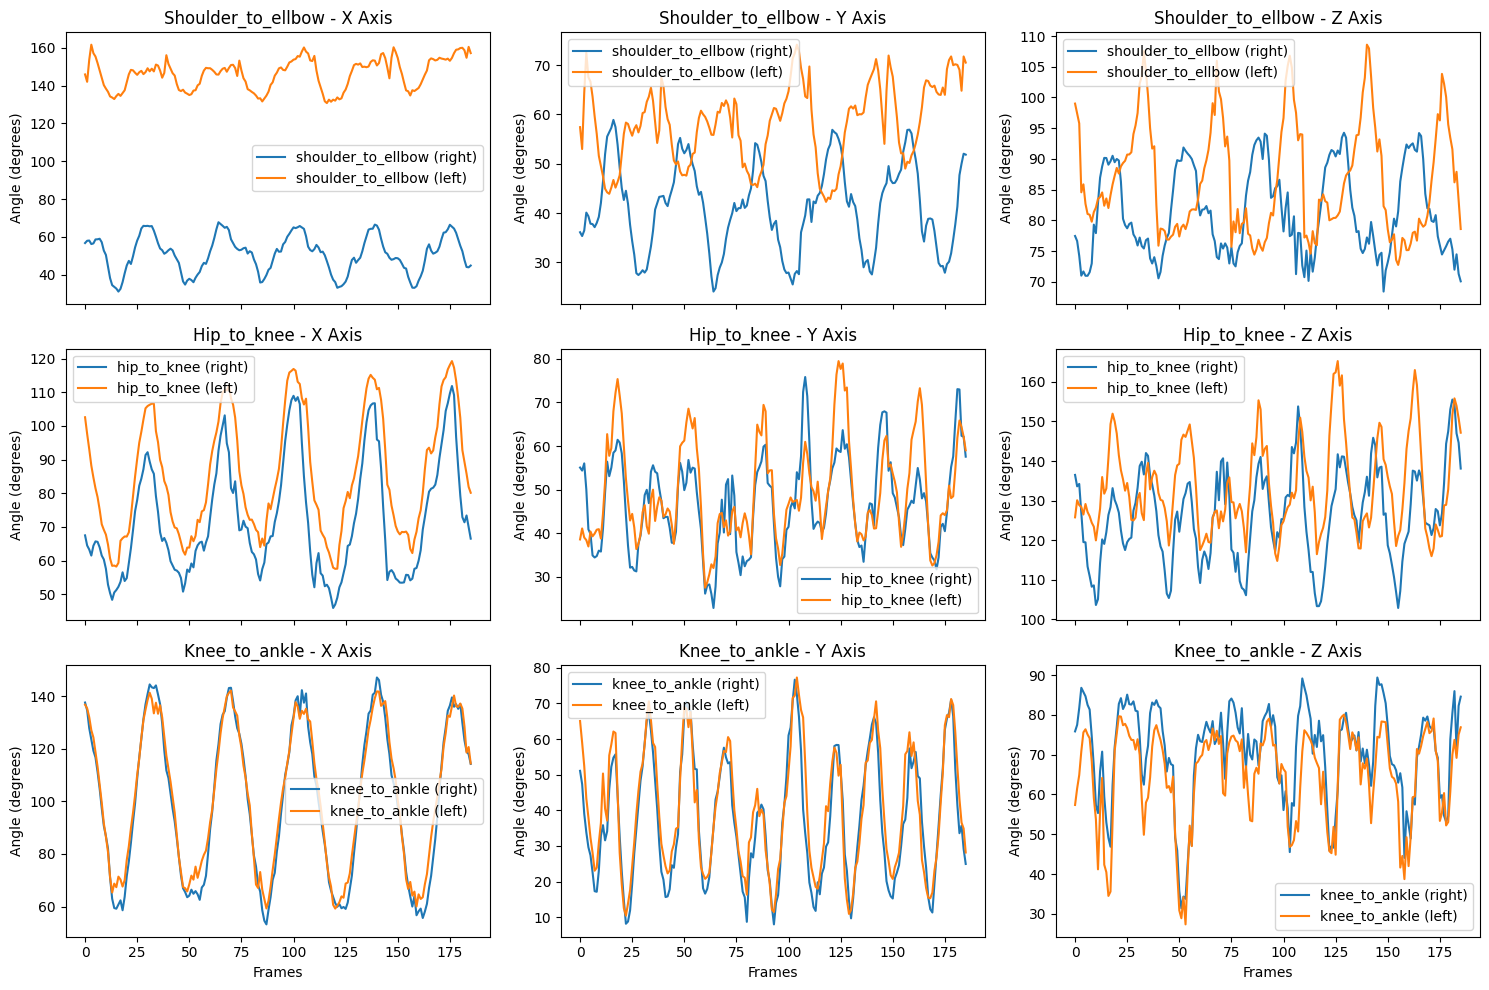

In [17]:
# Hier werden die Winkel der Joints (z.B. Oberarm) zu den Achsen berechnet (x, y und z)

import numpy as np
import matplotlib.pyplot as plt

def calculate_joint_angles(result):
    axis_vectors = {
        "x": np.array([1, 0, 0]),
        "y": np.array([0, 1, 0]),
        "z": np.array([0, 0, -1])
    }
    joint_angles = {}

    for i, frame in enumerate(result.keys()):
        joint_angles[i] = {}

        joints = result[frame]['3d_joints'][0]
        vectors = {
            "shoulder_to_ellbow_right": joints[r_ellbow_num] - joints[r_shoulder_num],
            "shoulder_to_ellbow_left": joints[l_ellbow_num] - joints[l_shoulder_num],
            "hip_to_knee_right": joints[r_knee_num] - joints[r_hip_num],
            "hip_to_knee_left": joints[l_knee_num] - joints[l_hip_num],
            "knee_to_ankle_right": joints[r_ankle_num] - joints[r_knee_num],
            "knee_to_ankle_left": joints[l_ankle_num] - joints[l_knee_num]
        }

        for axis_name, axis_vector in axis_vectors.items():
            joint_angles[i][axis_name] = {}

            for joint_name, joint_vector in vectors.items():
                angle = np.degrees(np.arccos(
                    np.dot(joint_vector, axis_vector) / (np.linalg.norm(joint_vector) * np.linalg.norm(axis_vector))
                ))
                joint_angles[i][axis_name][f"{axis_name}_{joint_name}_axis_angle"] = angle

    return joint_angles

def plot_joint_angles(joint_angles):
    frames = list(joint_angles.keys())
    joint_names = ["shoulder_to_ellbow", "hip_to_knee", "knee_to_ankle"]
    sides = ["right", "left"]
    axis_names = ["x", "y", "z"]

    fig, axs = plt.subplots(len(joint_names), len(axis_names), figsize=(15, 10), sharex=True)

    for j, joint in enumerate(joint_names):
        for a, axis in enumerate(axis_names):
            for side in sides:
                angle_key = f"{axis}_{joint}_{side}_axis_angle"
                angles = [joint_angles[frame][axis][angle_key] for frame in frames]
                axs[j, a].plot(frames, angles, label=f"{joint} ({side})")
            axs[j, a].set_title(f"{joint.capitalize()} - {axis.upper()} Axis")
            axs[j, a].set_ylabel("Angle (degrees)")
            axs[j, a].legend()

    for ax in axs[-1, :]:
        ax.set_xlabel("Frames")

    plt.tight_layout()
    plt.show()

# Berechnung der Winkel
joint_angles = calculate_joint_angles(result)

# Beispiel-Ausgabe für Frame 0
print(joint_angles[0])

# Plotten der Winkel
plot_joint_angles(joint_angles)


    # ACHTUNG: Mögliche Achsenspiegelung!
    # Es könnte sein, dass eine Körperseite (z. B. linke Schulter) in einem negativen Bereich des Koordinatensystems liegt.
    # In diesem Fall könnten die Winkel der linken Körperseite die gespiegelte Version der rechten Körperseite sein.
    # Das sieht man besonders bei den Schulter-Ellbogen-Winkeln, die fast genau gegensätzlich verlaufen bei SimonPD.

In [18]:
# Berechne die Winkel aller Achsen (Schulterachse, Hüftachse, Knieachse und Fußgelenksachse zu den drei Achsen des Koordinatensystems)
# r_hip_num = 9; r_knee_num = 10; r_ankle_num = 11; r_shoulder_num = 2
# l_hip_num = 12; l_knee_num = 13; l_ankle_num = 14; l_shoulder_num = 5

axis_vectors = {
    "x": np.array([1, 0, 0]),
    "y": np.array([0, 1, 0]),
    "z": np.array([0, 0, 1])
}

axis_angles = {}

def calculate_axis_angles(result):
    for i, frame in enumerate(result.keys()):
        axis_angles[i] = {}

        joints = result[frame]['3d_joints'][0]
        axes = {
            "shoulder": joints[r_shoulder_num] - joints[l_shoulder_num],
            "hip": joints[r_hip_num] - joints[l_hip_num],
            "knee": joints[r_knee_num] - joints[l_knee_num],
            "ankle": joints[r_ankle_num] - joints[l_ankle_num]
        }

        for axis_name, axis_vector in axis_vectors.items():
            axis_angles[i][axis_name] = {}

            for joint_name, joint_vector in axes.items():
                angle = np.degrees(np.arccos(np.dot(joint_vector, axis_vector) /
                                             (np.linalg.norm(joint_vector) * np.linalg.norm(axis_vector))))
                axis_angles[i][axis_name][f"{axis_name}_{joint_name}_axis_angle"] = angle

calculate_axis_angles(result)

# Beispiel-Ausgabe für Frame 0
print(axis_angles[0])





{'x': {'x_shoulder_axis_angle': np.float64(28.910582997901066), 'x_hip_axis_angle': np.float64(38.81314974877864), 'x_knee_axis_angle': np.float64(4.397903683624089), 'x_ankle_axis_angle': np.float64(22.07400835378148)}, 'y': {'y_shoulder_axis_angle': np.float64(71.52498795340898), 'y_hip_axis_angle': np.float64(66.79994323814802), 'y_knee_axis_angle': np.float64(94.39566239490595), 'y_ankle_axis_angle': np.float64(80.44208748173915)}, 'z': {'z_shoulder_axis_angle': np.float64(111.41375710263769), 'z_hip_axis_angle': np.float64(119.1770188771565), 'z_knee_axis_angle': np.float64(90.13928724409301), 'z_ankle_axis_angle': np.float64(70.29777755918246)}}


{'x': {'x_shoulder_axis_angle': np.float64(28.910582997901066), 'x_hip_axis_angle': np.float64(38.81314974877864), 'x_knee_axis_angle': np.float64(4.397903683624089), 'x_ankle_axis_angle': np.float64(22.07400835378148)}, 'y': {'y_shoulder_axis_angle': np.float64(71.52498795340898), 'y_hip_axis_angle': np.float64(66.79994323814802), 'y_knee_axis_angle': np.float64(94.39566239490595), 'y_ankle_axis_angle': np.float64(80.44208748173915)}, 'z': {'z_shoulder_axis_angle': np.float64(111.41375710263769), 'z_hip_axis_angle': np.float64(119.1770188771565), 'z_knee_axis_angle': np.float64(90.13928724409301), 'z_ankle_axis_angle': np.float64(70.29777755918246)}}


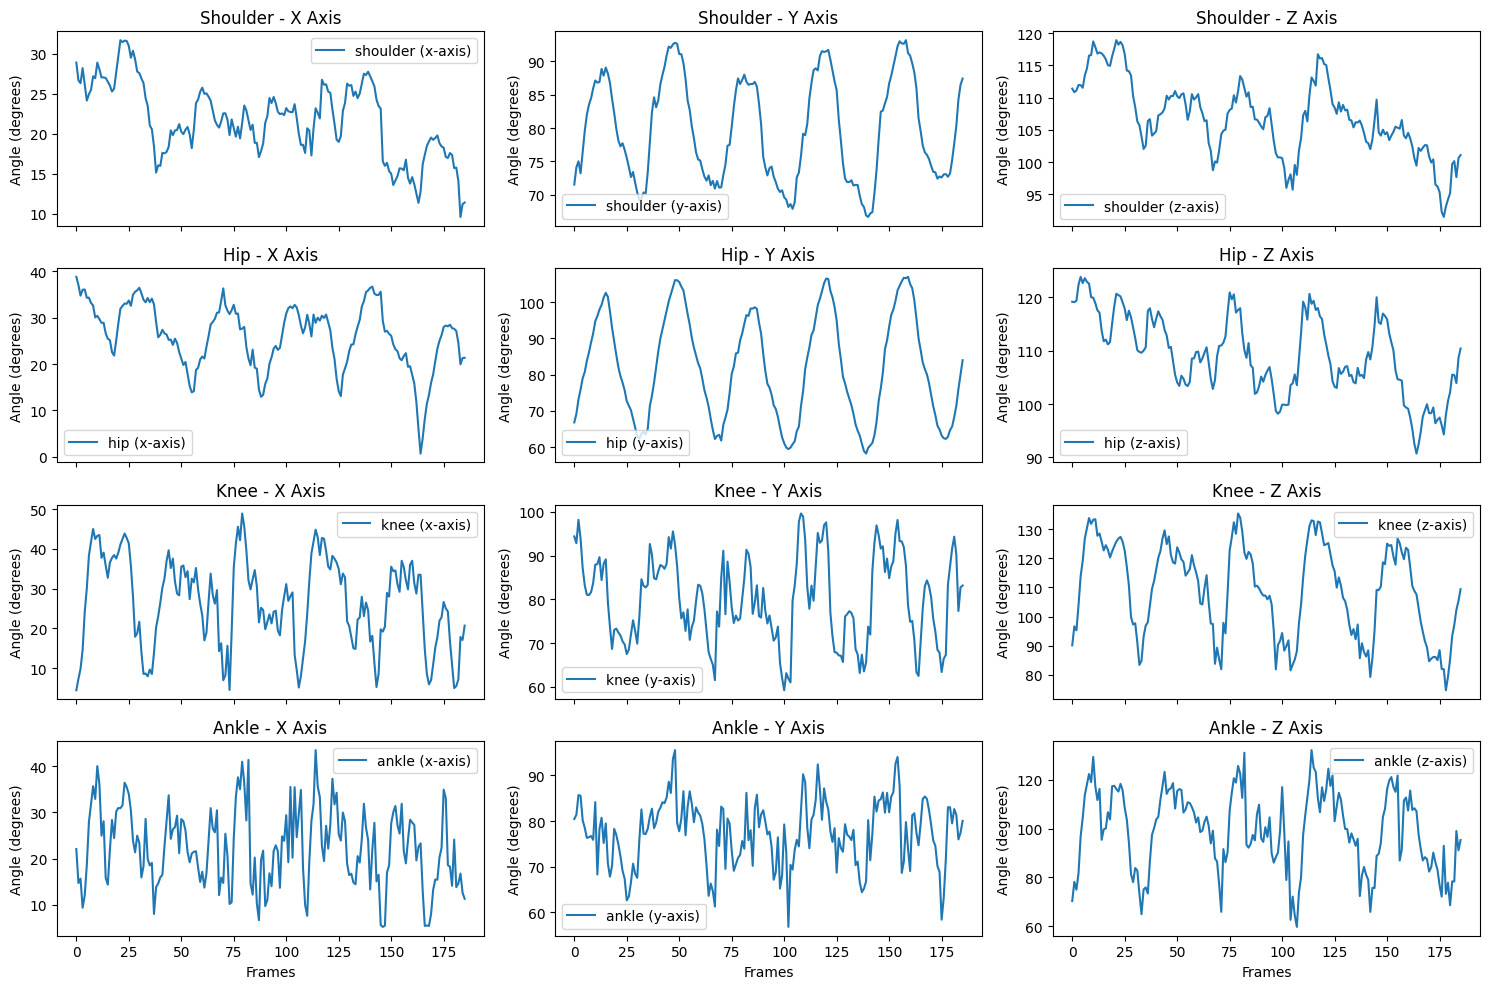

In [19]:
import matplotlib.pyplot as plt

def calculate_axis_angles(result):
    axis_vectors = {
        "x": np.array([1, 0, 0]),
        "y": np.array([0, 1, 0]),
        "z": np.array([0, 0, 1])
    }
    axis_angles = {}

    for i, frame in enumerate(result.keys()):
        axis_angles[i] = {}

        joints = result[frame]['3d_joints'][0]
        axes = {
            "shoulder": joints[r_shoulder_num] - joints[l_shoulder_num],
            "hip": joints[r_hip_num] - joints[l_hip_num],
            "knee": joints[r_knee_num] - joints[l_knee_num],
            "ankle": joints[r_ankle_num] - joints[l_ankle_num]
        }

        for axis_name, axis_vector in axis_vectors.items():
            axis_angles[i][axis_name] = {}

            for joint_name, joint_vector in axes.items():
                angle = np.degrees(np.arccos(np.dot(joint_vector, axis_vector) /
                                             (np.linalg.norm(joint_vector) * np.linalg.norm(axis_vector))))
                axis_angles[i][axis_name][f"{axis_name}_{joint_name}_axis_angle"] = angle

    return axis_angles

def plot_axis_angles(axis_angles):
    frames = list(axis_angles.keys())
    joint_names = ["shoulder", "hip", "knee", "ankle"]
    axis_names = ["x", "y", "z"]

    fig, axs = plt.subplots(len(joint_names), len(axis_names), figsize=(15, 10), sharex=True)

    for j, joint in enumerate(joint_names):
        for a, axis in enumerate(axis_names):
            angles = [axis_angles[frame][axis][f"{axis}_{joint}_axis_angle"] for frame in frames]
            axs[j, a].plot(frames, angles, label=f"{joint} ({axis}-axis)")
            axs[j, a].set_title(f"{joint.capitalize()} - {axis.upper()} Axis")
            axs[j, a].set_ylabel("Angle (degrees)")
            axs[j, a].legend()

    for ax in axs[-1, :]:
        ax.set_xlabel("Frames")

    plt.tight_layout()
    plt.show()

# Berechnung der Winkel
axis_angles = calculate_axis_angles(result)

# Beispiel-Ausgabe für Frame 0
print(axis_angles[0])

# Plotten der Winkel
plot_axis_angles(axis_angles)


In [20]:
x_vector = np.array([1, 0, 0])
y_vector = np.array([0, 1, 0])
z_vector = np.array([0, 0, 1])


COM_angles = {}

for i, frame in enumerate(list(result.keys())):
    COM_angle = {}

    # Berechne den Vektor vom Knöchel-Mittelpunkt zum COM
    ground_to_COM_vector = np.array(COM_xyz_values[i]) - np.array(center_ankle[i])

    # Berechne die Winkel zur x-, y- und z-Achse
    COM_x_rotation = np.degrees(np.arccos(np.dot(ground_to_COM_vector, x_vector) / (np.linalg.norm(ground_to_COM_vector) * np.linalg.norm(x_vector))))
    COM_y_rotation = np.degrees(np.arccos(np.dot(ground_to_COM_vector, y_vector) / (np.linalg.norm(ground_to_COM_vector) * np.linalg.norm(y_vector))))
    COM_z_rotation = np.degrees(np.arccos(np.dot(ground_to_COM_vector, z_vector) / (np.linalg.norm(ground_to_COM_vector) * np.linalg.norm(z_vector))))

    COM_angle["COM_x_rotation"] = COM_x_rotation
    COM_angle["COM_y_rotation"] = COM_y_rotation
    COM_angle["COM_z_rotation"] = COM_z_rotation

    COM_angles[i] = COM_angle

print(COM_angles[0])


{'COM_x_rotation': np.float64(56.157620969365425), 'COM_y_rotation': np.float64(146.13587544977707), 'COM_z_rotation': np.float64(88.92628179367208)}


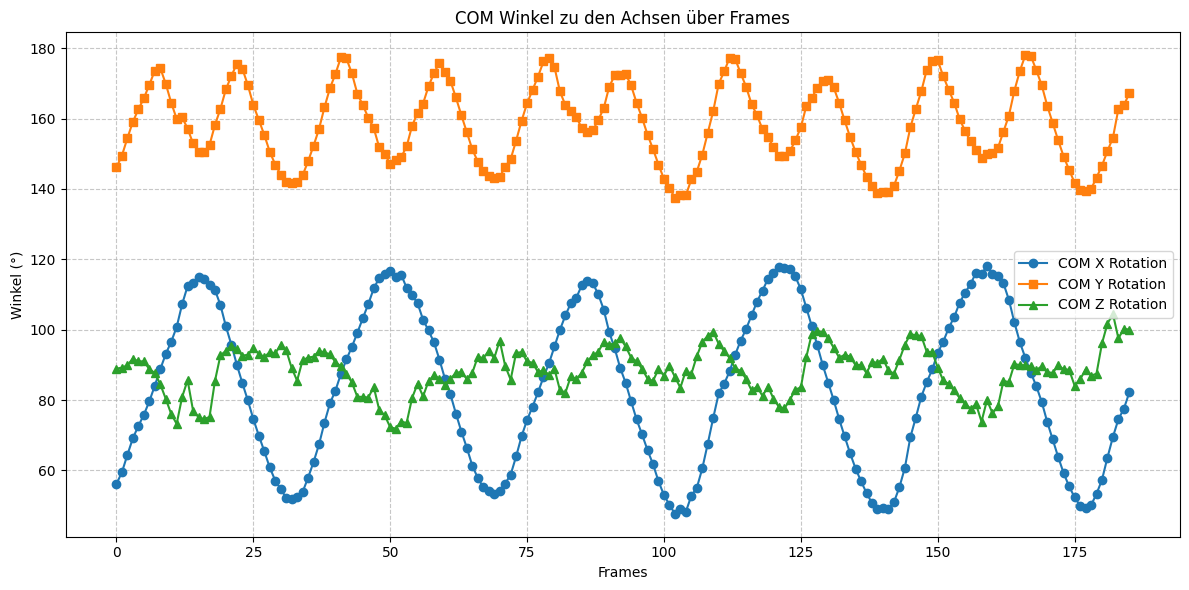

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_COM_angles(COM_angles):
    """
    Plottet die COM-Winkel zur x-, y- und z-Achse über alle Frames.

    Parameter:
    - COM_angles (dict): Dictionary mit Frame-Nummern als Schlüsseln und
                         Dictionaries der Winkel als Werte.
                         Beispiel:
                         {
                             0: {"COM_x_rotation": 30.0, "COM_y_rotation": 45.0, "COM_z_rotation": 60.0},
                             1: {"COM_x_rotation": 32.0, "COM_y_rotation": 46.0, "COM_z_rotation": 61.0},
                             ...
                         }
    """
    frames = sorted(COM_angles.keys())

    # Listen der Winkelwerte
    COM_x = [COM_angles[frame].get("COM_x_rotation", np.nan) for frame in frames]
    COM_y = [COM_angles[frame].get("COM_y_rotation", np.nan) for frame in frames]
    COM_z = [COM_angles[frame].get("COM_z_rotation", np.nan) for frame in frames]

    plt.figure(figsize=(12, 6))

    # Plot für jede Achse
    plt.plot(frames, COM_x, label='COM X Rotation', marker='o')
    plt.plot(frames, COM_y, label='COM Y Rotation', marker='s')
    plt.plot(frames, COM_z, label='COM Z Rotation', marker='^')

    # Achsenbeschriftungen und Titel
    plt.xlabel('Frames')
    plt.ylabel('Winkel (°)')
    plt.title('COM Winkel zu den Achsen über Frames')

    # Legende und Gitter
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Beispielhafte Nutzung der Funktion
# Stelle sicher, dass dein 'COM_angles'-Dictionary bereits definiert und gefüllt ist
plot_COM_angles(COM_angles)


In [22]:
# Speichern der Features in pkl file - alle Features werden in Dictionary mit jeweiligem Nanen gespeichert, so kann man später auf diese zugreifen beim Training
# Feature 1: Center of Mass Distance to Ground
print(COM_to_ground)

# Feature 2: Knee Angles Right & Left
print(knee_angles_right)
print(knee_angles_left)

# Feature 3: beinhaltet Winkel für den Oberarm (Schulter zu Ellbogen), Oberschenkel (Hüfte zu Knie) sowie Unterschenkel (Knie zu Fußgelenk) zu den drei Achsen des Koordinatensystems (x, y und z)
print(joint_angles)

# Feature 4: berechnet den Winkel der Achsen (Schulterachse, Hüftachse, Knieachse und Fußgelenksachse) zu den drei Achsen des Koordinatensystems (x, y und z)
print(axis_angles)

# Feature 5: Center of Mass Winkel zu den drei Achsen -> die Achsen sind immer ein globaler referenzvektor (1, 0, 0), (0, 1, 0), (0, 0, 1)
print(COM_angles)

{0: np.float32(0.7292355), 1: np.float32(0.73043066), 2: np.float32(0.74673116), 3: np.float32(0.7830828), 4: np.float32(0.8178987), 5: np.float32(0.8205116), 6: np.float32(0.8378239), 7: np.float32(0.8452063), 8: np.float32(0.8408417), 9: np.float32(0.82669276), 10: np.float32(0.82438695), 11: np.float32(0.78465956), 12: np.float32(0.7849536), 13: np.float32(0.7628496), 14: np.float32(0.7318114), 15: np.float32(0.70748025), 16: np.float32(0.6569973), 17: np.float32(0.6270044), 18: np.float32(0.6625599), 19: np.float32(0.71619207), 20: np.float32(0.7357655), 21: np.float32(0.76961696), 22: np.float32(0.8049782), 23: np.float32(0.8279485), 24: np.float32(0.85313123), 25: np.float32(0.8545417), 26: np.float32(0.8573738), 27: np.float32(0.8570687), 28: np.float32(0.84377265), 29: np.float32(0.833208), 30: np.float32(0.823153), 31: np.float32(0.7836964), 32: np.float32(0.74356693), 33: np.float32(0.72746825), 34: np.float32(0.71044046), 35: np.float32(0.7121442), 36: np.float32(0.73348856)

In [23]:
import pickle

# Features in ein Dictionary packen
features_dict = {
    "COM_to_ground": COM_to_ground,
    "knee_angles_right": knee_angles_right,
    "knee_angles_left": knee_angles_left,
    "joint_angles": joint_angles,
    "axis_angles": axis_angles,
    "COM_angles": COM_angles
}

# Als .pkl speichern
with open("features.pkl", "wb") as pkl_file:
    pickle.dump(features_dict, pkl_file)

# Als .txt speichern (für visuelle Überprüfung)
with open("features.txt", "w") as txt_file:
    for key, value in features_dict.items():
        txt_file.write(f"{key}:\n{value}\n\n")

print("Speicherung abgeschlossen: 'features.pkl' und 'features.txt'")


Speicherung abgeschlossen: 'features.pkl' und 'features.txt'


In [26]:
import pickle

# erlaubte Fahrstile: CL, EKK, PD, PDK, PDL, PDL2, PGK, PGL, PGL2, PS, CL2, PS2
fahrstil = "EKK"

# 🔹 Features laden (falls sie schon gespeichert wurden)
with open("features.pkl", "rb") as pkl_file:
    features_dict = pickle.load(pkl_file)

num_frames = len(features_dict["COM_to_ground"])
print(num_frames)

labels = {}
label_fahrstil = fahrstil

# 1 steht für Linksschwung, 2 für Rechtsschwung
schwungbereiche = [
  (0, 18, 1),
  (19, 33, 2),
  (34, 55, 1),
  (56, 70, 2),
  (71, 89, 1),
  (90, 104, 2),
  (105, 124, 1),
  (125, 141, 2),
  (142, 161, 1),
  (162, 176, 2),
  (177, 185, 1),
]

for start, end, schwungbereich in schwungbereiche:
  for i in range(start, end + 1):
    labels[i] = schwungbereich


# 🔹 Labels in Dictionary speichern
features_dict["schwung_labels"] = labels
features_dict["fahrstil"] = label_fahrstil

# 🔹 Neue Daten speichern (mit Labels)
with open("features_with_labels.pkl", "wb") as pkl_file:
    pickle.dump(features_dict, pkl_file)

with open("features_with_labels.txt", "w") as txt_file:
    for key, value in features_dict.items():
        txt_file.write(f"{key}:\n{value}\n\n")

print("Speicherung abgeschlossen: 'features_with_labels.pkl' und 'features_with_labels.txt'")


186
Speicherung abgeschlossen: 'features_with_labels.pkl' und 'features_with_labels.txt'
